In [62]:
import sys
sys.path.append('../')

In [79]:
import json
from zipfile import ZipFile
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from sklearn.neighbors import KernelDensity

from data_loading import ChatHighlightData
import utils

## Video info from zipped download

In [8]:
vid_info = list()

info_files_path = "../data/video_info/*_vids.json"
info_files = glob.glob(info_files_path)

for f_name in info_files:
    with open(f_name, "r") as info_file:
        vid_info.extend(json.load(info_file))

# for lookup later
vid2ind = {v["id"]:i for i, v in enumerate(vid_info)}

In [9]:
vid_info[vid2ind["83571434"]]

{'id': '83571434',
 'stream_id': '22827014832',
 'user_id': '30707866',
 'user_login': 'esl_lol',
 'user_name': 'ESL_LOL',
 'title': 'RERUN: fnatic vs. Millenium - Group A - IEM Katowice 2014 - League of Legends',
 'description': '',
 'created_at': '2016-08-14T14:26:23Z',
 'published_at': '2016-08-14T14:26:23Z',
 'url': 'https://www.twitch.tv/videos/83571434',
 'thumbnail_url': 'https://static-cdn.jtvnw.net/cf_vods/d2nvs31859zcd8/ad3ef727c7_esl_lol_22827014832_500493871/thumb/thumb0-%{width}x%{height}.jpg',
 'viewable': 'public',
 'view_count': 36,
 'language': 'en',
 'type': 'archive',
 'duration': '18h30m39s',
 'muted_segments': None}

In [49]:
chat_files_path = "../data/videos_chat/*_vids_chat.zip"
chat_files = glob.glob(chat_files_path)


for chat_file_name in chat_files:
    zf = ZipFile(chat_file_name)
    for f_name in zf.namelist():
        # print(f_name)if f_name.endswith("json") else None
        if f_name.endswith("json"):
            with zf.open(f_name, "r") as in_file:
                vid_chat = json.load(in_file)
                v_ind = vid2ind[f_name.split("/")[-1].strip(".json")]
                chat_info = {
                    "msg_count": len(vid_chat["comments"]),
                    "is_rerun": vid_info[v_ind]["title"].startswith("RERUN") or vid_info[v_ind]["title"].startswith("REBROADCAST") # might want to add more filters in future
                }

                vid_info[v_ind].update(chat_info)

In [16]:
vid_info_filtered = [vinf for vinf in vid_info if "msg_count" in vinf.keys()]

## Video info into dataframe

In [2]:
"""
cols = ["id", "title", "created_at", "msg_count", "is_rerun", "duration"]

df_vid_info = pd.DataFrame(vid_info_filtered, columns=cols)
df_vid_info["created_at"] = pd.to_datetime(df_vid_info["created_at"])
"""
df_vid_info = pd.read_csv("../data/video_info/vid_info.csv")
df_vid_info

,Unnamed: 0,id,title,created_at,msg_count,is_rerun,duration
0,0,227102357,CDL Apertura 2019 Semana 3,2018-02-09 00:45:28+00:00,3874,False,4h27m52s
1,1,225381050,LLN Apertura 2018 S3 Día 2,2018-02-03 19:45:22+00:00,4457,False,1h25m18s
2,2,225068727,LLN Apertura 2018 S3 Día 1,2018-02-02 22:45:18+00:00,10065,False,3h49m24s
3,3,224766976,CDL Apertura 2018 Semana 2,2018-02-02 00:45:30+00:00,5975,False,4h21m25s
4,4,223003357,LLN Apertura 2018 S2 Día 2,2018-01-27 19:45:02+00:00,6873,False,2h34m17s
...,...,...,...,...,...,...,...
5949,5949,69488592,LCK Summer - Week 2 Day 1: AFS vs. SSG (OGN),2016-05-30 10:46:44+00:00,9010,False,2h19m28s
5950,5950,69052411,LCK Summer - Week 1 Day 4: JAG vs. LZ,2016-05-28 04:44:00+00:00,7634,False,2h19m44s
5951,5951,68882512,LCK Summer - Week 1 Day 3: MVP vs. KT (OGN),2016-05-27 10:47:11+00:00,10036,False,2h42m56s
5952,5952,68694328,LCK Summer - Week 1 Day 2: ROX vs. SSG (OGN),2016-05-26 10:46:49+00:00,14758,False,2h42m2s


In [3]:
hours, dur = zip(*[d.split("h") if "h" in d else (0,d) for d in df_vid_info.duration])
minutes, dur = zip(*[d.split("m") if "m" in d else (0,d) for d in dur])
seconds, _ = zip(*[d.split("s") if "s" in d else (0,d) for d in dur])

hours = np.asarray(hours, dtype=int)
minutes = np.asarray(minutes, dtype=int)
seconds = np.asarray(seconds, dtype=int)

df_vid_info["duration_hrs"] = hours + minutes/60 + seconds/(60*60)

In [4]:
#delete 0 length stream
df_vid_info = df_vid_info.drop(df_vid_info[df_vid_info["duration_hrs"] == 0].index)

In [5]:
rerun_markers = ["(RE-BROADCAST)", "(REBROADCAST)","REBROADCAST:","RERUNL:","RERUN:","Rerun:","[Rebroadcast]","RERUN","REBROADCAST"]

In [6]:
df_vid_info["is_rerun"] = df_vid_info.apply(lambda x: bool(min(1, x["is_rerun"] + sum([x["title"].startswith(k) for k in rerun_markers]))), axis=1).to_numpy()

In [7]:
df_vid_info["msg_per_min"] = df_vid_info.apply(lambda x: x["msg_count"]/(x["duration_hrs"]*60),axis=1)

In [8]:
df_vid_info

,Unnamed: 0,id,title,created_at,msg_count,is_rerun,duration,duration_hrs,msg_per_min
0,0,227102357,CDL Apertura 2019 Semana 3,2018-02-09 00:45:28+00:00,3874,False,4h27m52s,4.464444,14.462419
1,1,225381050,LLN Apertura 2018 S3 Día 2,2018-02-03 19:45:22+00:00,4457,False,1h25m18s,1.421667,52.250879
2,2,225068727,LLN Apertura 2018 S3 Día 1,2018-02-02 22:45:18+00:00,10065,False,3h49m24s,3.823333,43.875327
3,3,224766976,CDL Apertura 2018 Semana 2,2018-02-02 00:45:30+00:00,5975,False,4h21m25s,4.356944,22.856232
4,4,223003357,LLN Apertura 2018 S2 Día 2,2018-01-27 19:45:02+00:00,6873,False,2h34m17s,2.571389,44.547910
...,...,...,...,...,...,...,...,...,...
5949,5949,69488592,LCK Summer - Week 2 Day 1: AFS vs. SSG (OGN),2016-05-30 10:46:44+00:00,9010,False,2h19m28s,2.324444,64.603250
5950,5950,69052411,LCK Summer - Week 1 Day 4: JAG vs. LZ,2016-05-28 04:44:00+00:00,7634,False,2h19m44s,2.328889,54.632634
5951,5951,68882512,LCK Summer - Week 1 Day 3: MVP vs. KT (OGN),2016-05-27 10:47:11+00:00,10036,False,2h42m56s,2.715556,61.595745
5952,5952,68694328,LCK Summer - Week 1 Day 2: ROX vs. SSG (OGN),2016-05-26 10:46:49+00:00,14758,False,2h42m2s,2.700556,91.080025


In [9]:
df_vid_info[df_vid_info.msg_count.isna()] # missing videos

,Unnamed: 0,id,title,created_at,msg_count,is_rerun,duration,duration_hrs,msg_per_min


In [10]:
df_vid_info.describe()

,Unnamed: 0,id,msg_count,duration_hrs,msg_per_min
count,5953.000000,5.953000e+03,5953.000000,5953.000000,5953.000000
mean,2976.138922,3.187749e+08,15733.779607,6.361180,43.619916
std,1718.834639,3.586141e+08,34000.960054,8.103318,80.568819
min,0.000000,3.590598e+06,0.000000,0.000278,0.000000
25%,1488.000000,3.812734e+07,0.000000,2.897778,0.000000
50%,2976.000000,1.501160e+08,1229.000000,5.471111,7.998690
75%,4464.000000,4.826927e+08,14297.000000,6.876667,46.996744
max,5953.000000,1.419109e+09,409973.000000,89.180833,586.882192


In [52]:
df_vid_info.sort_values("duration_hrs", ascending=False)

,Unnamed: 0,id,title,created_at,msg_count,is_rerun,duration,duration_hrs,msg_per_min
1263,1263,30009722,RERUN: Team WE vs. TSM - IEM Katowice 2015 - G...,2013-12-26 22:08:10+00:00,0,True,89h10m51s,89.180833,0.000000
982,982,51850869,RERUN: Team Curse vs Gambit Gaming - Group A -...,2016-03-02 05:20:58+00:00,3791,True,47h57m9s,47.952500,1.317623
886,886,67804358,RERUN: Azubu Frost vs Gambit Gaming - Match 2 ...,2016-05-21 20:44:50+00:00,240,True,47h57m5s,47.951389,0.083418
918,918,61083342,RERUN: fnatic vs SK Telecom T1 Game 2 - IEM Co...,2016-04-17 01:21:51+00:00,365,True,47h57m5s,47.951389,0.126865
1036,1036,30986044,RERUN: Team SoloMid vs. LGD Gaming - IEM 2015 ...,2015-12-20 21:34:30+00:00,0,True,47h57m4s,47.951111,0.000000
...,...,...,...,...,...,...,...,...,...
3288,3288,30072948,2015 All-Star Event Rebroadcast - Day 4,2015-01-16 04:43:04+00:00,0,False,6s,0.001667,0.000000
1112,1112,30006333,RERUN: Team WE vs. TSM - IEM Katowice 2015 - G...,2015-03-30 16:03:41+00:00,0,True,5s,0.001389,0.000000
3750,3750,38127627,Riot Season 2 World Finals -- Playoffs,2012-10-06 20:52:48+00:00,0,False,5s,0.001389,0.000000
558,558,151406797,RERUN: ROX Tigers vs. H2K - Group A Winners Ga...,2017-06-12 21:08:30+00:00,0,True,2s,0.000556,0.000000


In [11]:
df_vid_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5953 entries, 0 to 5953
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    5953 non-null   int64  
 1   id            5953 non-null   int64  
 2   title         5953 non-null   object 
 3   created_at    5953 non-null   object 
 4   msg_count     5953 non-null   int64  
 5   is_rerun      5953 non-null   bool   
 6   duration      5953 non-null   object 
 7   duration_hrs  5953 non-null   float64
 8   msg_per_min   5953 non-null   float64
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 424.4+ KB


In [12]:
#vid_info_out = "../data/videos_chat/vid_info.csv"
#df_vid_info.to_csv(vid_info_out)

In [13]:
df_commented_vids = df_vid_info[df_vid_info.msg_count > 0]
f"{df_commented_vids.id.count()}/{df_vid_info.id.count()} videos with comments"

'4072/5953 videos with comments'

In [14]:
df_reruns = df_vid_info[df_vid_info.is_rerun]
print(f"{df_reruns.id.count()}/{df_vid_info.id.count()} videos are reruns (approx)")

946/5953 videos are reruns (approx)


In [15]:
print(f"{sum(df_reruns.msg_count > 0)}/{df_reruns.id.count()} reruns have comments")

586/946 reruns have comments


In [16]:
print(f"{df_reruns.msg_count.mean()} comments per rerun video on average") # maybe an approximate cutoff for what to sort out

3697.881606765328 comments per rerun video on average


In [17]:
print(f"{df_commented_vids.msg_count.sum()} comments in total")

93663190 comments in total


In [18]:
print(f"{df_commented_vids.msg_count.mean()} comments per video on average")

23001.765717092338 comments per video on average


In [19]:
print(f"oldest video from\t{df_vid_info.created_at.min()}\nmost recent video from\t{df_vid_info.created_at.max()}")

oldest video from	2012-05-29 11:43:41+00:00
most recent video from	2022-03-08 07:48:50+00:00


In [20]:
print(f"oldest video with comments from\t{df_commented_vids.created_at.min()}\nmost recent video with comments from\t{df_commented_vids.created_at.max()}")

oldest video with comments from	2016-03-02 05:20:58+00:00
most recent video with comments from	2022-03-08 07:48:50+00:00


In [21]:
print(f"{df_commented_vids.msg_count.sum()/(df_commented_vids.duration_hrs.sum()*60)} comments per minute on average")

56.726654638890906 comments per minute on average


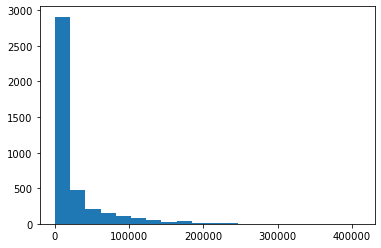

In [22]:
n, bins, _ = plt.hist(df_commented_vids.msg_count,bins=20)
plt.show()

In [23]:
list(zip(n[:5],bins[:5]))

[(2910.0, 1.0),
 (476.0, 20499.6),
 (205.0, 40998.2),
 (149.0, 61496.799999999996),
 (103.0, 81995.4)]

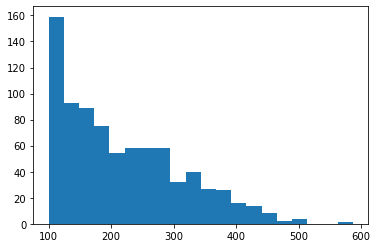

In [24]:
n, bins, _ = plt.hist(df_commented_vids.msg_per_min,bins=20, range=(100,df_commented_vids.msg_per_min.max()))
plt.show()

messages per minute helps us to characterize the VODs:

In [ ]:
sum(n)

In [ ]:
len(set(df_vid_info.title))

In [26]:
df_vid_info.title.count()

5953

## Duplicates
There are no duplicated videos, however there are duplicated titles. This seems to stem from:

a) some titles being " " one whitespace only

b) some streams being stopped and restarted with the same title

In [27]:
df_vid_info[df_vid_info.duplicated()].id.count()

0

In [28]:
print(f"{df_vid_info.title.duplicated().sum()} duplicated titles")

1918 duplicated titles


In [ ]:
set(df_vid_info[df_vid_info.title.duplicated()].title)

In [33]:
df_vid_info[df_vid_info.title.duplicated()].sort_values("title")

,Unnamed: 0,id,title,created_at,msg_count,is_rerun,duration,duration_hrs,msg_per_min
1635,1635,1013003053,,2021-05-06 11:38:35+00:00,151294,False,7h46m12s,7.770000,324.525955
1636,1636,1013003051,,2021-05-06 11:38:35+00:00,0,False,7h46m12s,7.770000,0.000000
1643,1643,979788223,,2021-04-08 11:45:45+00:00,14460,False,5h9m25s,5.156944,46.733100
1495,1495,1155878473,,2021-09-22 10:55:28+00:00,0,False,1h56m22s,1.939444,0.000000
2241,2241,368573688,,2019-01-23 17:52:34+00:00,54,False,4m25s,0.073611,12.226415
...,...,...,...,...,...,...,...,...,...
385,385,1115852655,🔴 LIVE - ESL Mobile Open presents Wild Rift Oc...,2021-08-12 07:31:14+00:00,256,False,2h10m39s,2.177500,1.959434
535,535,164771991,🔴 LIVE: Return of the Legends - Team NA vs Te...,2017-08-06 01:45:19+00:00,16,False,48s,0.013333,20.000000
542,542,160383037,🔴 [LIVE] ESL Premiership - 2017 Autumn Group S...,2017-07-19 17:44:44+00:00,0,False,3m12s,0.053333,0.000000
541,541,160383776,🔴 [LIVE] ESL Premiership - 2017 Autumn Group S...,2017-07-19 17:48:04+00:00,1,False,4m48s,0.080000,0.208333


In [34]:
df_vid_info[df_vid_info.title == " "]

,Unnamed: 0,id,title,created_at,msg_count,is_rerun,duration,duration_hrs,msg_per_min
1494,1494,1155878474,,2021-09-22 10:55:28+00:00,29528,False,1h56m22s,1.939444,253.749642
1495,1495,1155878473,,2021-09-22 10:55:28+00:00,0,False,1h56m22s,1.939444,0.000000
1635,1635,1013003053,,2021-05-06 11:38:35+00:00,151294,False,7h46m12s,7.770000,324.525955
1636,1636,1013003051,,2021-05-06 11:38:35+00:00,0,False,7h46m12s,7.770000,0.000000
1643,1643,979788223,,2021-04-08 11:45:45+00:00,14460,False,5h9m25s,5.156944,46.733100
2082,2082,448475597,,2019-07-05 06:24:35+00:00,13650,False,6h38m55s,6.648611,34.217673
2241,2241,368573688,,2019-01-23 17:52:34+00:00,54,False,4m25s,0.073611,12.226415


In [35]:
df_vid_info[df_vid_info.title.duplicated()].sort_values("title").iloc[0].title

' '

some streams actually have no title https://www.twitch.tv/videos/1013003053

## Filtering out videos to reduce the number of messages

Discard videos without messages

In [81]:
df_reduced = df_vid_info[df_vid_info.msg_count > 0]
f"{df_commented_vids.id.count()}/{df_vid_info.id.count()} videos with comments"

'4072/5953 videos with comments'

discard reruns

In [82]:
# to look at stream titles, write them to file
# with open("stream_titles.txt", "w") as out_file:
#    out_file.write("\n".join(sorted(df_commented_vids.title.unique().tolist())))

In [83]:
df_reduced = df_reduced[df_reduced.is_rerun==False]

In [84]:
df_reduced = df_reduced[df_reduced["duration_hrs"] >= 1]

In [85]:
# df_reduced = df_reduced[df_reduced["msg_per_min"] >= 300]

In [86]:
df_reduced.id.count(),df_reduced.msg_count.sum()

(3110, 89960287)

In [47]:
df_reduced.sort_values("duration_hrs", ascending=False)

,Unnamed: 0,id,title,created_at,msg_count,is_rerun,duration,duration_hrs,msg_per_min
1936,1936,506331985,PRESHOW | Finals | 2019 World Championship | G...,2019-11-10 04:05:29+00:00,235568,False,12h4m52s,12.081111,324.981146
974,974,52477612,SKT vs CLG - IEM Katowice 2016 - group B,2016-03-05 10:38:03+00:00,264144,False,11h36m23s,11.606389,379.308331
2834,2834,61178465,LCS Spring Playoffs - Finals: OG vs G2 | CLG v...,2016-04-17 13:58:47+00:00,230420,False,11h30m16s,11.504444,333.813019
4147,4147,732975955,Warm Up Finals Preshow | LEC Summer (2020) |Le...,2020-09-06 08:00:39+00:00,234119,False,11h23m24s,11.390000,342.579748
980,980,52259670,LIVE: IEM Katowice 2016,2016-03-04 10:44:57+00:00,259020,False,11h6m14s,11.103889,388.782709
...,...,...,...,...,...,...,...,...,...
4165,4165,663187389,Week 3 Day 2 | LEC Summer Split (2020): OG vs....,2020-06-27 17:26:10+00:00,58269,False,2h50m3s,2.834167,342.658042
1982,1982,485355544,2019 World Championship Draw Show,2019-09-23 12:30:11+00:00,50895,False,2h28m18s,2.471667,343.189481
1958,1958,495468093,Legends of Runeterra with Pastrytime and Andre...,2019-10-16 18:01:12+00:00,47512,False,2h18m13s,2.303611,343.750151
2854,2854,57989033,League of Draven Caster Showdown,2016-04-01 17:01:02+00:00,40041,False,1h58m5s,1.968056,339.091037


In [50]:
df_reduced.describe()

,Unnamed: 0,id,msg_count,duration_hrs,msg_per_min
count,151.000000,1.510000e+02,151.000000,151.000000,151.000000
mean,2459.814570,4.386562e+08,153574.198675,6.965432,367.257931
std,914.324584,3.115202e+08,50049.773854,2.051003,48.195257
min,972.000000,5.225967e+07,30185.000000,1.005833,302.146496
25%,1959.500000,1.840128e+08,117874.500000,5.619306,328.958000
50%,2276.000000,3.455940e+08,156511.000000,7.220556,354.108056
75%,2614.500000,5.443060e+08,181030.000000,8.137083,398.780118
max,5769.000000,1.211185e+09,280448.000000,12.081111,507.795565


## Interesting observations

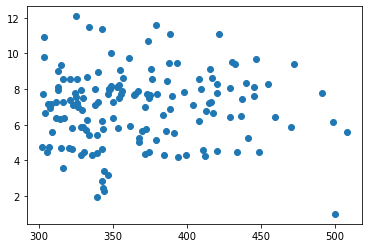

In [54]:
plt.scatter(df_reduced.msg_per_min, df_reduced.duration_hrs)
plt.show()

In [57]:
scipy.stats.pearsonr(df_reduced.msg_per_min, df_reduced.duration_hrs)

(0.014865720551946023, 0.856238022307642)

## Distribution of message densities in matches of Fu et. al dataset

In [67]:
chd = ChatHighlightData(chat_dir="../data/final_data", highlight_dir="../data/gt",)
chd.load_data(file_identifier="nalcs*")

In [68]:
data_totals = chd.get_data_totals()

In [69]:
data_totals["chat_message_count"]/(data_totals["video_length_secs"]/60)

174.60866602711147

characteristics of message counts per video where one __video__ is one __match__ in the tournament

In [72]:
msg_counts =  list()
video_lengths = list()
for match, data in chd.chat.items():
    msg_counts.append(len(utils.unpack_messages(data)))
    video_lengths.append(len(data))

In [73]:
np.std(msg_counts)

5364.576250815363

In [74]:
video_lens_mins = np.asarray(video_lengths)/30/60

In [75]:
video_msg_per_min = np.asarray(msg_counts)/video_lens_mins

## Selecting VODs based on distributions in our highlight data

We can model the distributions of different features of the videos in our data and then sample VODs based on these criteria until we have a certain amount of tokens

Follow this guide to get the bi-modal distribution out: https://machinelearningmastery.com/probability-density-estimation/

In [76]:
def model_from_samples(s, b):
    # fit density
    sample = s.reshape((-1, 1))
    m = KernelDensity(bandwidth=b, kernel='gaussian')
    return m.fit(s)

In [77]:
def plot_model(v, model):
    # sample probabilities for a range of outcomes
    values = np.arange(0,v.max(),1)
    values = values.reshape((-1, 1))
    probabilities = m.score_samples(values)
    probabilities = np.exp(probabilities)
    
    # plot the histogram and pdf
    plt.hist(v, bins=50, density=True)
    plt.plot(values[:], probabilities)
    plt.show()

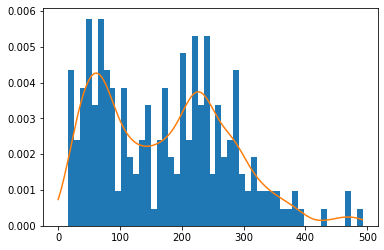

In [80]:
vals = video_msg_per_min.reshape((-1,1))
m = model_from_samples(vals, 20)
plot_model(vals, m)

In [175]:
df_sampled_vids = pd.DataFrame(columns=df_reduced.columns)

while df_sampled_vids.msg_count.sum() < 2*10**7:
    val = m.sample()[0,0]
    idx = df_reduced.msg_per_min.apply(lambda x: abs(x-val)).idxmin()
    df_sampled_vids = pd.concat([df_sampled_vids, df_reduced[df_reduced.index == idx]])

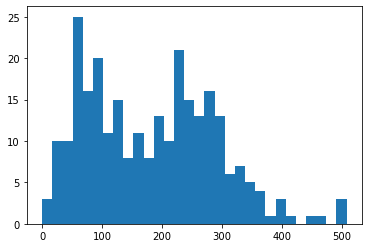

In [177]:
plt.hist(df_sampled_vids.msg_per_min,bins=30)
plt.show()

In [179]:
df_sampled_vids.msg_count.sum()

20011366

In [181]:
list(df_sampled_vids.title)

['Group Stage Day 3 | Mid-Season Invitational (2018)',
 'The Dive Podcast | Classic Legends',
 '2016 Mid-Season Invitational: Group Stage Day 2',
 'Worlds 2018 Group Stage Day 8',
 'Week 1 Day 1 | LEC Summer Split (2020)',
 'DK vs DRXㅣT1 vs LSB | 2021 LCK Summer',
 'DK vs T1 | HLE vs LSB | 2022 LCK Spring Split',
 'LCK Summer: KZ vs. KT - GEN vs. GRF',
 'EU Challenger Spring - Semifinals Day 2',
 'G2 vs. MAD | Playoffs Round 1 | LEC Summer | G2 Esports vs. MAD Lions (2020)',
 'BLG vs. JDG | IG vs. TES - Week 8 Day 7 | LPL Summer Split (2020)',
 'Week 5 Day 1 | LCS Spring Split (2019)',
 'AF vs. DRX - SB vs. T1 [2020 LCK Summer Split]',
 '2018 World Championship: Play-In Day 4',
 'Week 4 Day 2 | LEC Summer Split (2020)',
 'EU LCS Promotion Tournament - Day 3',
 'Group Stage Day 3 | Mid-Season Invitational (2018)',
 'WE vs. DMO | JDG vs. EDG - Week 6 Day 1 | LPL Summer Split (2020)',
 'VIT vs FNC - EU LCS Spring Playoffs Quarterfinals Day 1',
 'SP vs. HLE - DYN vs. DRX [2020 LCK Summer S